In [1]:
#Installing packages
!pip install squarify
!pip install statsmodels
!pip install seaborn
!pip install xgboost

In [1]:
#importing libraries
import numpy as np 
import pandas as pd 
import os
from statsmodels import api as sm
import pylab as py
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import seaborn as sns
import squarify
from scipy.stats import kstest,norm
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics
from scipy.stats import chi2_contingency

## **Dataset**


Ecommerce behaviour data from multi category store.

Dataset contains events of 285 million users from ecommerce website.

For purpose of analysis 2019 dataset is used.



In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
df = pd.read_csv(r'D:\huge_csvs\2019-Nov.csv')

In [5]:
df=reduce_mem_usage(df)

Memory usage after optimization is: 3733.74 MB
Decreased by 19.4%


In [6]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.0000,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.7500,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.3125,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,713.0000,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.2500,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67501979 entries, 0 to 67501978
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int32  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float16
 7   user_id        int32  
 8   user_session   object 
dtypes: float16(1), int32(2), int64(1), object(5)
memory usage: 3.6+ GB


# Rows

Each row in dataset describes an event.

There were around 6 crore 75 lakh rows present in initial dataset.

# Columns

There were 9 columns


In [8]:
#no of rows with null values
print("category_code ",df['category_code'].isnull().sum())
print("brand ",df['brand'].isnull().sum())
print("Both ",(df['category_code'].isnull() & df['brand'].isnull()).sum())

category_code  21898171
brand  9224078
Both  5709840




*   21 Lakh with missing category code
*   92 Lakhs with missing branch
*   Total  57 lakh with null values in category 
    code or branch or both

Since we have ample data we drop the data with null values and data is now reduced to 4 crores


In [9]:
df = df.dropna()

In [10]:
df.shape

(42089564, 9)

# No of visitors by date

To analyze the number of visitors by date we have grouped the dataset by columns event_time and user_id.

The no.of visitors on each date is extracted and shown in the graph below.


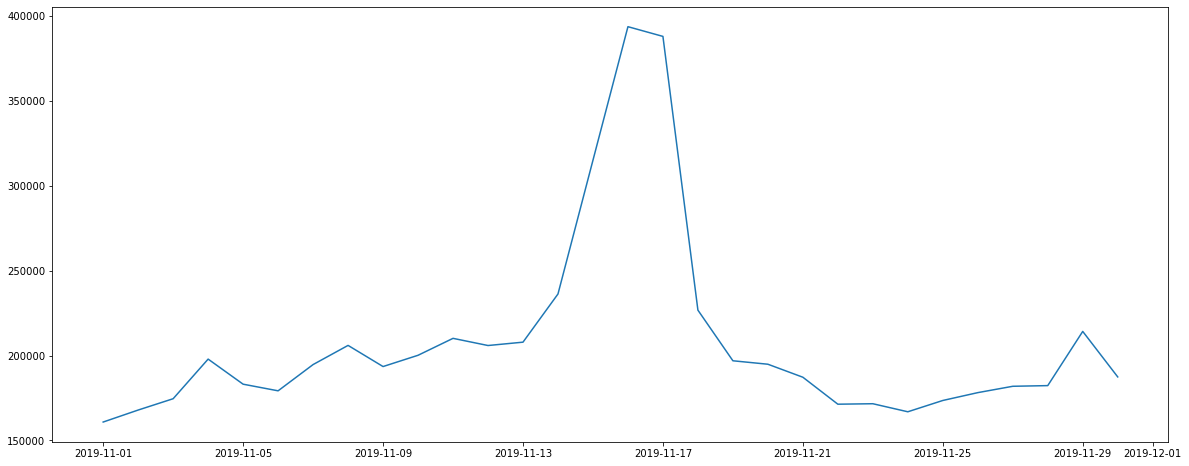

In [11]:
#No of visitors by date
data = df.loc[:,['event_time','user_id']]
#Extracting only dates
data['event_time'] = data['event_time'].apply(lambda s: str(s)[0:10])
visitor_by_date = data.drop_duplicates().groupby(['event_time'])['user_id'].agg(['count']).sort_values(by=['event_time'], ascending=True)
x = pd.Series(visitor_by_date.index.values).apply(lambda s: datetime.strptime(s, '%Y-%m-%d').date())
y = visitor_by_date['count']
plt.rcParams['figure.figsize'] = (20,8)

plt.plot(x,y)
plt.show()



*  There is a peak in the curve on 17th Nov 2019(Sunday).Based on the traffic we can infer that people are mostly free on sunday to shop.
*  Another peak could be found on  29th Nov 2019 which was Black Friday where the ecommerce websites displays the sneakpeak of all offers during the sale.



# Most bought brand

In [12]:
df['brand'].value_counts()
df['event_type'].value_counts()

view        39315226
cart         2115082
purchase      659256
Name: event_type, dtype: int64

            event_time  event_type  product_id  category_id  category_code  \
brand                                                                        
a-elita            320         320         320          320            320   
aardwolf           478         478         478          478            478   
abtoys              91          91          91           91             91   
accumaster          19          19          19           19             19   
acd                 50          50          50           50             50   
...                ...         ...         ...          ...            ...   
zpao                 6           6           6            6              6   
zte               9969        9969        9969         9969           9969   
zubr             10658       10658       10658        10658          10658   
zuru                 4           4           4            4              4   
zwerg               18          18          18           18     

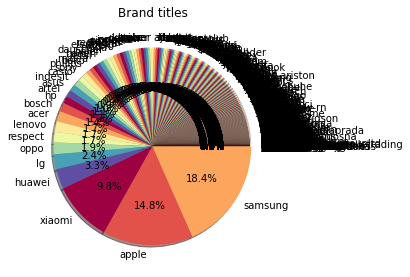

In [13]:
title_type = df.groupby('brand').agg('count')
print(title_type)
type_labels = title_type.user_id.sort_values().index
type_counts = title_type.user_id.sort_values()
plt.figure(1,figsize =(20,10))
the_grid = GridSpec(2,2)
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0,1,8)]
plt.subplot(the_grid[0,1],aspect=1,title = 'Brand titles')
type_show_ids = plt.pie(type_counts,labels = type_labels,autopct = '%1.1f%%',shadow = True,colors = colors)
plt.show()




 The above *piechart* shows the popularity of brands in the market with *"Samsung"* being the top brand




# Popular product categories

A squarify plot is used to visually represent which categories of product has drawn more demand from customer.

Most of the items are given two category codes separated by a point.First word depicts the main category of the item whereas the following word depicts its sub category.

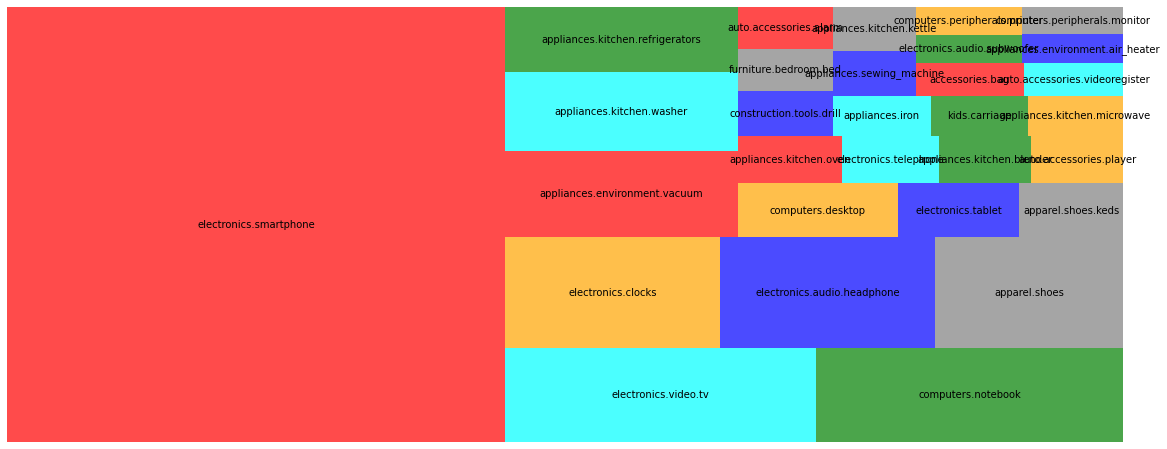

In [14]:

top_category_n = 30
top_category = df.loc[:,'category_code'].value_counts()[:top_category_n].sort_values(ascending=False)
squarify.plot(sizes=top_category, label=top_category.index.array, color=["red","cyan","green","orange","blue","grey"], alpha=.7  )
plt.axis('off')
plt.show()

"Smartphones" which comes under electronics goods are more popular.

A huge fraction of items bought are electronics which concludes there have been major discounts and price deals available on ecommerce platform.

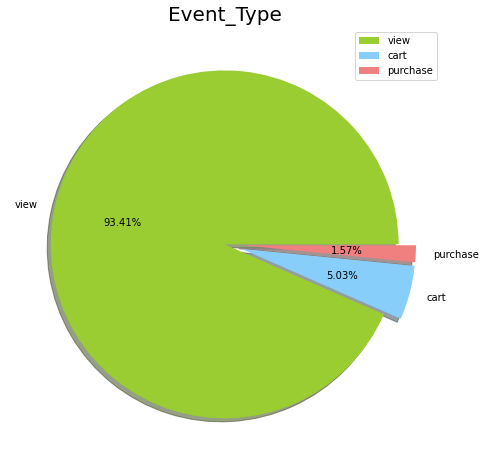

In [15]:
labels = ['view', 'cart','purchase']
size = df['event_type'].value_counts()
colors = ['yellowgreen', 'lightskyblue','lightcoral']
explode = [0, 0.1,0.1]

plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Event_Type', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

# Conversion Rates
We have three type of events view,add to cart and purchase.Not every user view ,add it to the cart and purchase it.Most users tend to have look at the product and its price.

Conversion rates gives us the idea of how many users actually purchased the product as opposed to how many times the products are viewed or added to the cart.

How many products are actually purchased as opposed to number of products added to the cart.

We find 


1.Count of people who viewed the item.

2.Count of people who added the item to cart.

3.Count of people who bought the item.

In [16]:
view_count = df['event_type'].value_counts()[0]
cart_count = df['event_type'].value_counts()[1]
purchase_count = df['event_type'].value_counts()[2]
print("Rate of conversion between view and purchase events" +str((purchase_count/view_count)*100) +'%')
print("Rate of conversion between view and add to cart events" +str((cart_count/view_count)*100) +'%')
print("Rate of conversion between add to cart and purchase events" +str((purchase_count/cart_count)*100) +'%')

Rate of conversion between view and purchase events1.676846522515221%
Rate of conversion between view and add to cart events5.379803743211345%
Rate of conversion between add to cart and purchase events31.169287999235962%


Rate of conversion from view to purchase is 1.67%

Rate of conversion from view to add to cart is 5.38%

Rate of conversion of buying the item which is added to the cart is 31.16%

There are some cases where no carting data is recorded before purchase which indicates that in some cases the customer directly purchases the product without adding it to the cart.


# Brandwise sales of all event types

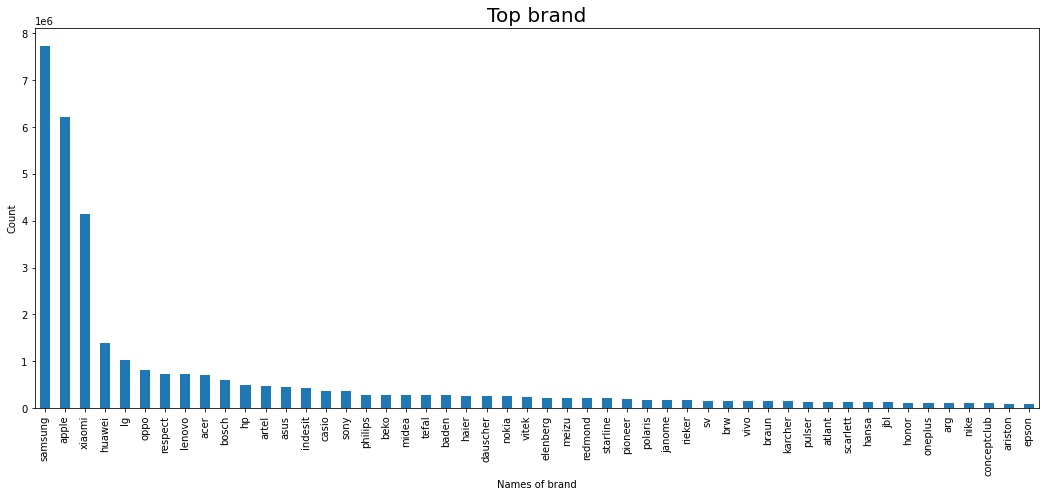

In [17]:
#Brandwise sales of all event types
df['brand'].value_counts().head(50).plot.bar(figsize = (18,7))
plt.title('Top brand',fontsize = 20)
plt.xlabel('Names of brand')
plt.ylabel('Count')
plt.show()


From the above plot we infer "Samsung" is the top brand where we consider all type of events(view,cart and purchase)


We consider only purchase events  which tells us which brand is the first player in the market

samsung     198669
apple       165681
xiaomi       57908
huawei       23466
oppo         15080
             ...  
wenyi            1
scooter          1
libero           1
easycamp         1
toro             1
Name: brand, Length: 1236, dtype: int64


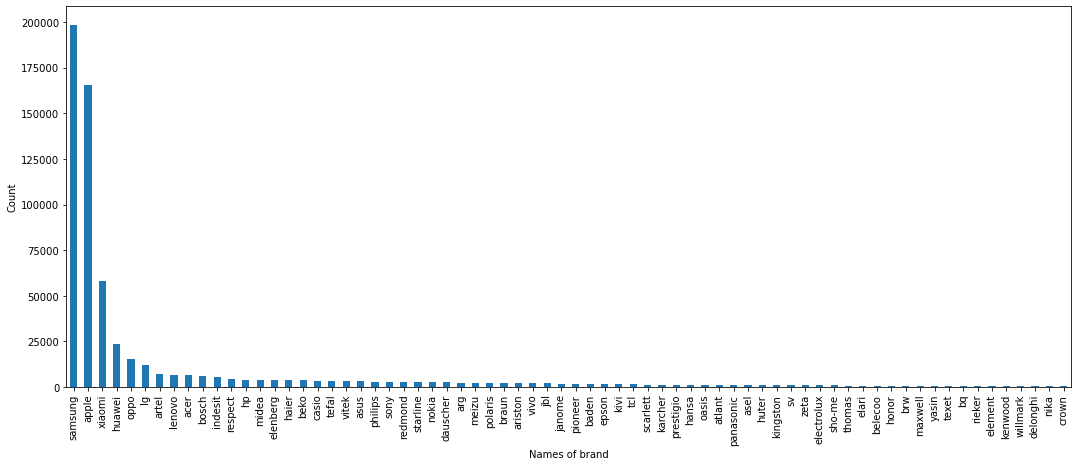

In [18]:

d = df.loc[df['event_type'].isin(['purchase'])].drop_duplicates()
print(d['brand'].value_counts())
d['brand'].value_counts().head(70).plot.bar(figsize =(18,7))
plt.xlabel('Names of brand')
plt.ylabel('Count')
plt.show()



*   As seen in the graph samsung is again the top in the market closely followed by apple.

*   A number of brands with only one product sale each including cameo,Imetec and Zapco take the last position.





In [19]:
top_player = df['brand'].value_counts()[0]
second_player = df['brand'].value_counts()[1]
last_player = df['brand'].value_counts()[-1]
print("Top brand saw " +str((top_player/second_player)*100)+"%more sales than second_player in the market")
print("Top brand saw " +str((top_player/last_player)*100)+"%more sales than bottom player in the market")

Top brand saw 124.45206713979948%more sales than second_player in the market
Top brand saw 773332700.0%more sales than bottom player in the market


# Purchase path
The standard idea is that most people first view an item,compare with other item and add to cart to buy specific item.not many people follow this path.

Given below is an example of customer who followed the path view->cart->purchase

In [20]:
df.loc[df.user_session =="ef3daa59-4936-43e5-a530-32902f64b2f4"].sort_values(by = "event_time")

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
2169,2019-11-01 00:14:32 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518840496,ef3daa59-4936-43e5-a530-32902f64b2f4
2275,2019-11-01 00:15:10 UTC,cart,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518840496,ef3daa59-4936-43e5-a530-32902f64b2f4
2309,2019-11-01 00:15:23 UTC,purchase,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518840496,ef3daa59-4936-43e5-a530-32902f64b2f4
2374,2019-11-01 00:15:46 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518840496,ef3daa59-4936-43e5-a530-32902f64b2f4


# User's journey

The code below shows the user who purchased a apple product after which he views other products manufactured by the same company "apple".

In [21]:
user_ID = 518267348
df.loc[df['user_id'] == user_ID]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
1748,2019-11-01 00:11:48 UTC,view,1005129,2053013555631882655,electronics.smartphone,apple,1337.0,518267348,61f913b1-ed5f-4495-8139-7e3e20be92c3
1822,2019-11-01 00:12:16 UTC,cart,1005129,2053013555631882655,electronics.smartphone,apple,1337.0,518267348,61f913b1-ed5f-4495-8139-7e3e20be92c3
1951,2019-11-01 00:13:10 UTC,purchase,1005129,2053013555631882655,electronics.smartphone,apple,1337.0,518267348,61f913b1-ed5f-4495-8139-7e3e20be92c3
2285,2019-11-01 00:15:14 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518267348,af95bb12-1956-40a4-a703-fcae492b2fb6
2520,2019-11-01 00:16:46 UTC,view,1005129,2053013555631882655,electronics.smartphone,apple,1337.0,518267348,4a1fa3dc-f7ed-4880-8e86-9b9f87045464
2678,2019-11-01 00:17:47 UTC,view,1005129,2053013555631882655,electronics.smartphone,apple,1337.0,518267348,4a1fa3dc-f7ed-4880-8e86-9b9f87045464
2706,2019-11-01 00:17:57 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518267348,4a1fa3dc-f7ed-4880-8e86-9b9f87045464
2800,2019-11-01 00:18:32 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518267348,4a1fa3dc-f7ed-4880-8e86-9b9f87045464
2868,2019-11-01 00:18:57 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518267348,4a1fa3dc-f7ed-4880-8e86-9b9f87045464
2875,2019-11-01 00:19:00 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518267348,4a1fa3dc-f7ed-4880-8e86-9b9f87045464


The user below views an android phone ,purchases the same and goes on to view other apple products clock and phone. He buys the apple clock.

The inference is apple customers wear brand loyalty.Apple customers have only viewed other products of apple whereas android customers view other company products also.


In [22]:
user_ID = 513351129
df.loc[df['user_id'] == user_ID]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
49,2019-11-01 00:00:17 UTC,view,1005161,2053013555631882655,electronics.smartphone,xiaomi,211.875,513351129,e6b7ce9b-1938-4e20-976c-8b4163aea11d
168,2019-11-01 00:01:04 UTC,purchase,1005161,2053013555631882655,electronics.smartphone,xiaomi,211.875,513351129,e6b7ce9b-1938-4e20-976c-8b4163aea11d
281,2019-11-01 00:01:57 UTC,view,1005161,2053013555631882655,electronics.smartphone,xiaomi,211.875,513351129,d3ff456e-0537-4c72-b126-752dd3e135db
57932963,2019-11-25 09:44:42 UTC,view,5100562,2053013553341792533,electronics.clocks,apple,334.500,513351129,ce2941e6-f108-4876-bb76-da3981eb92e9
57933375,2019-11-25 09:44:57 UTC,cart,5100562,2053013553341792533,electronics.clocks,apple,334.500,513351129,ce2941e6-f108-4876-bb76-da3981eb92e9
57933966,2019-11-25 09:45:21 UTC,view,5100562,2053013553341792533,electronics.clocks,apple,334.500,513351129,ce2941e6-f108-4876-bb76-da3981eb92e9
57934030,2019-11-25 09:45:23 UTC,cart,5100562,2053013553341792533,electronics.clocks,apple,334.500,513351129,ce2941e6-f108-4876-bb76-da3981eb92e9
57935200,2019-11-25 09:46:11 UTC,purchase,5100562,2053013553341792533,electronics.clocks,apple,334.500,513351129,ce2941e6-f108-4876-bb76-da3981eb92e9
60185950,2019-11-26 16:05:24 UTC,view,5100562,2053013553341792533,electronics.clocks,apple,334.500,513351129,543b61ca-c953-469d-95c9-71aeb2480749
60188988,2019-11-26 16:06:54 UTC,cart,5100562,2053013553341792533,electronics.clocks,apple,334.500,513351129,543b61ca-c953-469d-95c9-71aeb2480749


# Preparing data

To predict whether the product added to the cart is actually purchased by the customer based on factors such as its category,event_weekday,activity of the user in that session etc

We added some new features in training data


*   category_code_level1 - category
*   category_code_level2 - subcategory
*   event_weekday - weekday of the event
*   activity_count - no.of activity in that session

*   is_purchased - whether the put in cart item is purchased.


The training dataset contains every non-duplicated cart transactions with above mentioned features.We will use these features with original price and brand to predict whether the customer will eventuall purchase the item in the cart.









#List of people who has bought or added products to the cart

In [23]:
#List of people who has bought or added products to the cart
cart_purchase_users = df.loc[df["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['user_id'])
cart_purchase_users.dropna(how='any', inplace=True)
print(cart_purchase_users)

                       event_time event_type  product_id          category_id  \
40        2019-11-01 00:00:14 UTC       cart     1005014  2053013555631882655   
168       2019-11-01 00:01:04 UTC   purchase     1005161  2053013555631882655   
502       2019-11-01 00:03:24 UTC       cart     1801881  2053013554415534427   
537       2019-11-01 00:03:39 UTC       cart     1005115  2053013555631882655   
707       2019-11-01 00:04:51 UTC   purchase     1004856  2053013555631882655   
...                           ...        ...         ...                  ...   
67501311  2019-11-30 23:55:04 UTC       cart     1005130  2053013555631882655   
67501367  2019-11-30 23:55:28 UTC       cart     1005105  2053013555631882655   
67501558  2019-11-30 23:56:57 UTC       cart     1005212  2053013555631882655   
67501563  2019-11-30 23:57:01 UTC       cart     3701005  2053013565983425517   
67501666  2019-11-30 23:57:45 UTC       cart    28715769  2116907519078040377   

                          c

#All activities of above users including view event

In [24]:
cart_purchase_users_all_activity = df.loc[df['user_id'].isin(cart_purchase_users['user_id'])]
print(cart_purchase_users_all_activity)

                       event_time event_type  product_id          category_id  \
3         2019-11-01 00:00:01 UTC       view     3601530  2053013563810775923   
9         2019-11-01 00:00:02 UTC       view     1004258  2053013555631882655   
14        2019-11-01 00:00:05 UTC       view     4600658  2053013563944993659   
28        2019-11-01 00:00:10 UTC       view     1307350  2053013558920217191   
39        2019-11-01 00:00:14 UTC       view     1002544  2053013555631882655   
...                           ...        ...         ...                  ...   
67501953  2019-11-30 23:59:49 UTC       view     1801141  2053013554415534427   
67501965  2019-11-30 23:59:53 UTC       view     4804294  2053013554658804075   
67501975  2019-11-30 23:59:58 UTC       view    28719425  2053013565639492569   
67501976  2019-11-30 23:59:59 UTC       view     1004833  2053013555631882655   
67501977  2019-11-30 23:59:59 UTC       view     2701706  2053013563911439225   

                           

#Counting no of activities in one session

In [25]:

activity_in_session = cart_purchase_users_all_activity.groupby(['user_session'])['event_type'].count().reset_index()
activity_in_session = activity_in_session.rename(columns={"event_type":"activity_count"})
print(activity_in_session)

                                 user_session  activity_count
0        00001a36-7f5a-4c05-a52b-e9935de5331e               1
1        0000264c-75d2-4049-ab5d-93e6dd64650d               1
2        00002e0a-8b74-4c72-bb5a-99e04fa264da               4
3        00002ea0-6a36-47a9-acc9-5b0024c586f9               8
4        0000334c-e481-4c49-b66b-53e3d2e2d2d0               1
...                                       ...             ...
4285186  ffffee6f-ecc0-43c7-b0cd-13f4ce8d8172               2
4285187  fffff7d0-c21e-4a82-83f1-67685ce6ed1c               3
4285188  fffff826-edc8-4d19-9dd7-936ef133bc89               1
4285189  fffffbbe-9f76-403b-b17c-e7c68c48ea1c               4
4285190  fffffd01-5f95-4916-b2dd-491c603d6c9c               6

[4285191 rows x 2 columns]


Extract event date from event_time column and find on which date the activity occurs

In [26]:
def convert_time_to_date(utc_timestamp):
  utc_date = datetime.strptime(utc_timestamp[0:10],'%Y-%m-%d').date()
  return utc_date

In [27]:
df['event_date'] = df['event_time'].apply(lambda s:convert_time_to_date(s))

Splitting of category and sub category is done by string handling

In [34]:
df_targets = df.loc[df["event_type"].isin(["cart","purchase"])].drop_duplicates(subset = ['event_type','product_id','price','user_id','user_session'])
df_targets["is_purchased"] = np.where(df_targets["event_type"]=="purchase",1,0)
df_targets["is_purchased"] = df_targets.groupby(["user_session","product_id"])["is_purchased"].transform("max")
df_targets = df_targets.loc[df_targets["event_type"]=='cart'].drop_duplicates(["user_session","product_id","is_purchased"])
df_targets['event_weekday'] = df_targets['event_date'].apply(lambda s:s.weekday())
df_targets.dropna(how = 'any',inplace = True)
df_targets["category_code_level1"] = df_targets["category_code"].str.split(",",expand = True)[0].astype('category')
df_targets["category_code_level2"] = df_targets["category_code"].str.split(",",expand = True)[0].astype('category')

In [35]:
df_targets = df_targets.merge(activity_in_session,on = 'user_session',how ='left')
df_targets['activity_count'] = df_targets['activity_count'].fillna(0)
df_targets.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,is_purchased,event_weekday,category_code_level1,category_code_level2,activity_count
0,2019-11-01 00:00:14 UTC,cart,1005014,2053013555631882655,electronics.smartphone,samsung,503.000,533326659,6b928be2-2bce-4640-8296-0efdf2fda22a,2019-11-01,0,4,electronics.smartphone,electronics.smartphone,1
1,2019-11-01 00:03:24 UTC,cart,1801881,2053013554415534427,electronics.video.tv,samsung,488.750,557746614,4d76d6d3-fff5-4880-8327-e9e57b618e0e,2019-11-01,1,4,electronics.video.tv,electronics.video.tv,25
2,2019-11-01 00:03:39 UTC,cart,1005115,2053013555631882655,electronics.smartphone,apple,949.500,565865924,fd4bd6d4-bd14-4fdc-9aff-bd41a594f82e,2019-11-01,0,4,electronics.smartphone,electronics.smartphone,2
3,2019-11-01 00:05:54 UTC,cart,1002542,2053013555631882655,electronics.smartphone,apple,486.750,549256216,dcbdc6e4-cd49-4ee8-95c5-e85f3c618fa1,2019-11-01,0,4,electronics.smartphone,electronics.smartphone,14
4,2019-11-01 00:06:38 UTC,cart,1004856,2053013555631882655,electronics.smartphone,samsung,128.375,513645631,61ceaf50-820a-4858-9a68-bab804d47a22,2019-11-01,1,4,electronics.smartphone,electronics.smartphone,9


In [36]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1408569 entries, 0 to 1408568
Data columns (total 15 columns):
 #   Column                Non-Null Count    Dtype   
---  ------                --------------    -----   
 0   event_time            1408569 non-null  object  
 1   event_type            1408569 non-null  object  
 2   product_id            1408569 non-null  int32   
 3   category_id           1408569 non-null  int64   
 4   category_code         1408569 non-null  object  
 5   brand                 1408569 non-null  object  
 6   price                 1408569 non-null  float16 
 7   user_id               1408569 non-null  int32   
 8   user_session          1408569 non-null  object  
 9   event_date            1408569 non-null  object  
 10  is_purchased          1408569 non-null  int32   
 11  event_weekday         1408569 non-null  int64   
 12  category_code_level1  1408569 non-null  category
 13  category_code_level2  1408569 non-null  category
 14  activity_count    

In [37]:
#Saving a copy of preprocessed data
df_targets.to_csv('training_data.csv')

In [38]:
df_targets = pd.read_csv('training_data.csv')

In [39]:
df_targets.head()

,Unnamed: 0,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,is_purchased,event_weekday,category_code_level1,category_code_level2,activity_count
0,0,2019-11-01 00:00:14 UTC,cart,1005014,2053013555631882655,electronics.smartphone,samsung,503.0,533326659,6b928be2-2bce-4640-8296-0efdf2fda22a,2019-11-01,0,4,electronics.smartphone,electronics.smartphone,1
1,1,2019-11-01 00:03:24 UTC,cart,1801881,2053013554415534427,electronics.video.tv,samsung,488.8,557746614,4d76d6d3-fff5-4880-8327-e9e57b618e0e,2019-11-01,1,4,electronics.video.tv,electronics.video.tv,25
2,2,2019-11-01 00:03:39 UTC,cart,1005115,2053013555631882655,electronics.smartphone,apple,949.5,565865924,fd4bd6d4-bd14-4fdc-9aff-bd41a594f82e,2019-11-01,0,4,electronics.smartphone,electronics.smartphone,2
3,3,2019-11-01 00:05:54 UTC,cart,1002542,2053013555631882655,electronics.smartphone,apple,486.8,549256216,dcbdc6e4-cd49-4ee8-95c5-e85f3c618fa1,2019-11-01,0,4,electronics.smartphone,electronics.smartphone,14
4,4,2019-11-01 00:06:38 UTC,cart,1004856,2053013555631882655,electronics.smartphone,samsung,128.4,513645631,61ceaf50-820a-4858-9a68-bab804d47a22,2019-11-01,1,4,electronics.smartphone,electronics.smartphone,9


#Resampling data to have equal no of purchased and not purchased items

no.of rows when the item was purchased was around 5 lakh and not purchased was around 8 lakh.

To balance data resampling is done

In [40]:

is_purchase_set = df_targets[df_targets['is_purchased'] == 1]
is_purchase_set.shape[0]

522866

In [41]:
not_purchase_set = df_targets[df_targets['is_purchased'] == 0]
not_purchase_set.shape[0]

885703

In [42]:
n_samples = 500000
is_purchase_downsampled = resample(is_purchase_set,replace = False,n_samples = n_samples,random_state = 27)
not_purchase_set_downsampled = resample(not_purchase_set,replace = False,n_samples = n_samples,random_state = 27)

In [43]:
downsampled = pd.concat([is_purchase_downsampled,not_purchase_set_downsampled])
downsampled['is_purchased'].value_counts()

1    500000
0    500000
Name: is_purchased, dtype: int64

In [44]:
features = downsampled[['brand','price','event_weekday','category_code_level1','category_code_level2','activity_count']]

#Encoding categorical attributes

In [47]:

features.loc[:,'brand'] =LabelEncoder().fit_transform(downsampled.loc[:,'brand'].copy())
features.loc[:,'event_weekday'] = LabelEncoder().fit_transform(downsampled.loc[:,'event_weekday'].copy())
features.loc[:,'category_code_level1'] = LabelEncoder().fit_transform(downsampled.loc[:,'category_code_level1'].copy())
features.loc[:,'category_code_level2'] = LabelEncoder().fit_transform(downsampled.loc[:,'category_code_level2'].copy())
is_purchased = LabelEncoder().fit_transform(downsampled['is_purchased'])
features.head()

D:\Data_Analytics_Bootcamp\Anaconda\envs\mlenv\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,brand,price,event_weekday,category_code_level1,category_code_level2,activity_count
235095,1042,95.25,1,11,11,9
1104998,4,1002.50,3,71,71,5
1268236,1088,168.80,2,98,98,20
103485,75,500.80,4,98,98,8
798825,1088,244.00,6,98,98,8


In [48]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 235095 to 868963
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   brand                 1000000 non-null  int32  
 1   price                 1000000 non-null  float64
 2   event_weekday         1000000 non-null  int64  
 3   category_code_level1  1000000 non-null  int32  
 4   category_code_level2  1000000 non-null  int32  
 5   activity_count        1000000 non-null  int64  
dtypes: float64(1), int32(3), int64(2)
memory usage: 42.0 MB


#Hypothesis testing - atrribute dependence

In [49]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.00,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,2019-11-01
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.75,530496790,8e5f4f83-366c-4f70-860e-ca7417414283,2019-11-01
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,713.00,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f,2019-11-01
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.25,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2,2019-11-01
5,2019-11-01 00:00:01 UTC,view,1306894,2053013558920217191,computers.notebook,hp,360.00,520772685,816a59f3-f5ae-4ccd-9b23-82aa8c23d33c,2019-11-01


#Chi square test - association between two attributes

Weekday vs price

In [51]:
import scipy.stats as stats
from scipy.stats import chi2_contingency

user_id vs category_id

In [55]:
d1 =df[:100000]
table1 = pd.crosstab(d1['category_id'],d1['user_id'],margins = False)
stat,p,dof,expected = chi2_contingency(table1)
alpha = 0.05
print("For category code and user")
print("p value is " +str(p))
if p >= alpha:
  print("No significant association between these attributes -H0 holds true")
else:
  print("significant association between these attributes -H0 is rejected")



For category code and user
p value is 0.0
significant association between these attributes -H0 is rejected


#Time series analysis

In [90]:
parse_date = ['date']
parse_time = ['time']
df.head()


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.00,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,2019-11-01
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.75,530496790,8e5f4f83-366c-4f70-860e-ca7417414283,2019-11-01
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,713.00,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f,2019-11-01
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.25,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2,2019-11-01
5,2019-11-01 00:00:01 UTC,view,1306894,2053013558920217191,computers.notebook,hp,360.00,520772685,816a59f3-f5ae-4ccd-9b23-82aa8c23d33c,2019-11-01


In [91]:
timeseries_df = df[['date','event_type']]
plt.plot('xlabel','ylabel',data =timeseries_df)
plt.show()

KeyError: "['date'] not in index"

#Covariance matrix

In [60]:

matrix = downsampled[['brand','price','event_weekday','category_code_level1','category_code_level2','activity_count','is_purchased']]
matrix.loc[:,'brand'] = LabelEncoder().fit_transform(downsampled.loc[:,'brand'].copy())
matrix.loc[:,'event_weekday'] = LabelEncoder().fit_transform(downsampled.loc[:,'event_weekday'].copy())
matrix.loc[:,'category_code_level1'] = LabelEncoder().fit_transform(downsampled.loc[:,'category_code_level1'].copy())
matrix.loc[:,'category_code_level2'] = LabelEncoder().fit_transform(downsampled.loc[:,'category_code_level2'].copy())
matrix.head()

D:\Data_Analytics_Bootcamp\Anaconda\envs\mlenv\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,brand,price,event_weekday,category_code_level1,category_code_level2,activity_count,is_purchased
235095,1042,95.25,1,11,11,9,1
1104998,4,1002.50,3,71,71,5,1
1268236,1088,168.80,2,98,98,20,1
103485,75,500.80,4,98,98,8,1
798825,1088,244.00,6,98,98,8,1


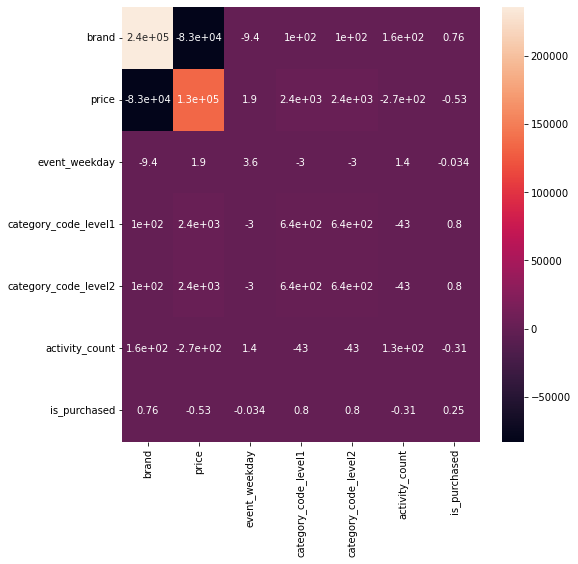

In [61]:
cov_matrix = matrix.cov()
sns.heatmap(cov_matrix,annot = True)
plt.show()

#Correlation matrix

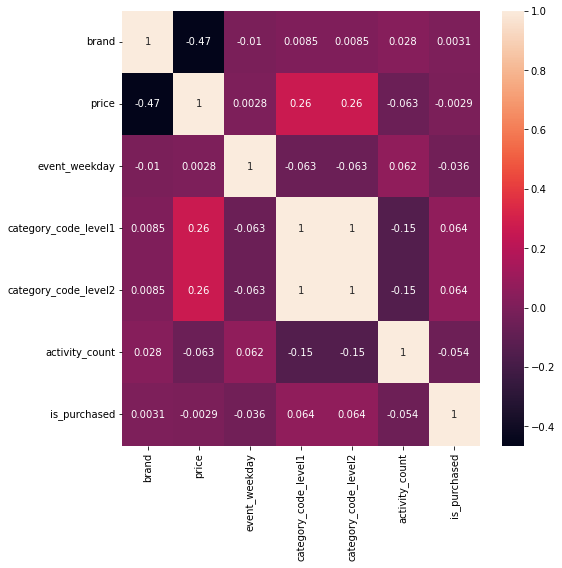

In [62]:

corr_matrix = matrix.corr()
sns.heatmap(corr_matrix,annot = True)
plt.show()

#ML models

In [74]:
#Train Test split
X_train, X_test, y_train,y_test = train_test_split(features, is_purchased, test_size=0.25, random_state=0)

#Decision tree classification

In [83]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
dt_model = dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

In [84]:
print("Accuracy",metrics.accuracy_score(y_test,y_pred))
print("Precision",metrics.precision_score(y_test,y_pred))
print("Recall",metrics.recall_score(y_test,y_pred))
print("fbeta",metrics.fbeta_score(y_test,y_pred,average = 'weighted',beta=0.5))

Accuracy 0.673528
Precision 0.6640013932111245
Recall 0.7019057605032937
fbeta 0.6736368378127295


#XGBoost classification

In [79]:

from xgboost import XGBClassifier
xg_model = XGBClassifier(learning_rate = 0.1)
xg_model.fit(X_train,y_train)
y_pred = xg_model.predict(X_test)

In [80]:
print("Accuracy",metrics.accuracy_score(y_test,y_pred))
print("Precision",metrics.precision_score(y_test,y_pred))
print("Recall",metrics.recall_score(y_test,y_pred))
print("fbeta",metrics.fbeta_score(y_test,y_pred,average = 'weighted',beta=0.5))

Accuracy 0.6976
Precision 0.6735617141932443
Recall 0.7662581941298414
fbeta 0.6985067758947878


#Logisitic Regression Attempt 1

In [76]:

from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
log_model = log_model.fit(X_train,y_train)
y_pred = log_model.predict(X_test)

In [77]:
print("Accuracy",metrics.accuracy_score(y_test,y_pred))
print("Precision",metrics.precision_score(y_test,y_pred))
print("Recall",metrics.recall_score(y_test,y_pred))
print("fbeta",metrics.fbeta_score(y_test,y_pred,average = 'weighted',beta=0.5))

Accuracy 0.52652
Precision 0.5218706080608527
Recall 0.6271160664975147
fbeta 0.5239308004436298


TypeError: unsupported operand type(s) for *: 'datetime.date' and 'float'

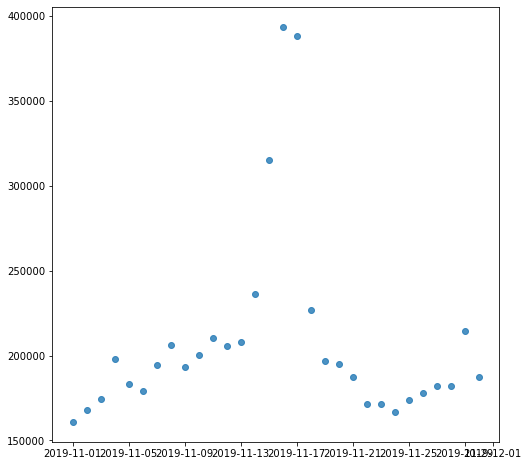

In [93]:
import seaborn as sns

sns.regplot(x=x, y=y, data=df, logistic=True, ci=None)